<a href="https://colab.research.google.com/github/sammyculotta/PHY122-Lab/blob/main/phy122_lab5t.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PHY122 Lab 5: Pendulum

Michael Culotta

04/28/25

#   <font color='Green'> **Setup** </font>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, linewidth=200, threshold=2000, suppress=True)

π = np.pi

In [3]:
import scipy
from scipy.special import ellipj, ellipk

def get_radian(deg):
    return π * deg / 180

def get_degree(rad):
    return 180 * rad / π

def get_ω(time):
    dtt = time[1] - time[0]
    return 2*π * np.linspace(0.0, 1.0/(2.0*dtt), int(len(time)/2))

def get_Qdot(Q, L, IIi):

    ω = np.append([0.],  IIi @ L)

    B = 0.5*np.asarray([[ Q[0], -Q[1], -Q[2], -Q[3] ],
                        [ Q[1],  Q[0], -Q[3],  Q[2] ],
                        [ Q[2],  Q[3],  Q[0], -Q[1] ],
                        [ Q[3], -Q[2],  Q[1],  Q[0] ]])

    return B @ ω

def get_EulerAngles(Q):

    φ = np.arctan2( 2*(Q[0]*Q[1] + Q[2]*Q[3]) , 1 - 2*(Q[1]**2 + Q[2]**2) )
    θ = np.arcsin(  2*(Q[0]*Q[2] + Q[3]*Q[1] ) ) ## np.tan() ?? np.arcsin
    ψ = np.arctan2( 2*(Q[0]*Q[3] + Q[1]*Q[2]) , 1 - 2*(Q[2]**2 + Q[3]**2) )

    return np.asarray([φ, θ, ψ])

def get_Qauternions(Θ):

    φ = Θ[0]
    θ = Θ[1]
    ψ = Θ[2]

    ## Q[0] has all cosines, then for each component replace one sine, then add/subtract the flip of this
    Q = np.asarray([ np.cos(φ/2)*np.cos(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.sin(φ/2)*np.cos(θ/2)*np.cos(ψ/2) - np.cos(φ/2)*np.sin(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.sin(θ/2)*np.cos(ψ/2) + np.sin(φ/2)*np.cos(θ/2)*np.sin(ψ/2),
                     np.cos(φ/2)*np.cos(θ/2)*np.sin(ψ/2) - np.sin(φ/2)*np.sin(θ/2)*np.cos(ψ/2)])

    return Q

def sn(arg, k):
    sn = scipy.special.ellipj( arg , k)[0]
    return np.nan_to_num(sn, nan=1.)


def EllipticK(k):
    return scipy.special.ellipk(k)


class PhysicalPendulum(object):
    # 6/30/21
    ''' Pendulum Initialization '''
    def __init__(self):

        ### Constants
        self.g    = 9.81 # meters/second-squared : gravitational acceleration
        self.L    = 1.00 # meters : moment-of-inertia length
        #self.R    = 1.00 # meters : rotation-arm length
        self.drag = 0.00 # kg/seconds : Stokes drag / viscous damping coefficient
        self.mass = 1.00 # kg

        ### calculated constants
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        ### calculations
        self.angle0      = None
        self.dynamicsrun = None
        self.dynamicst   = None
        self.freqprofile = None
        self.freq        = None

    def dynamics(self, Θ_0, dt=0.01, T=100, ω_0=[0.,0.,0.], error=0.25, dimension=1):

        ### calculated constants
        self.Θ    = Θ_0
        self.I    = self.mass * (self.L)**2 # moment-of-inerta for point-mass around L
        self.II   = self.I * np.eye(3)
        self.IIi  = np.linalg.inv(self.II)
        self.C1   = self.IIi * self.drag
        self.C2   = self.IIi * self.L * self.mass * self.g
        self.ω0   = np.sqrt( self.C2[0][0] )

        self.angle0 = Θ_0
        Θ_0    = np.asarray([Θ_0, 0.0, 0.0])
        Θ_0    = get_radian(Θ_0)
        L      = self.II @ ω_0
        time   = np.arange(0, T, dt)
        Q      = get_Qauternions(Θ_0)
        θ_data = np.zeros( (time.shape[0], 3) )

        for i in range(len(time)):

            θ_data[i] = get_degree( get_EulerAngles(Q) + (Θ_0[0]/180) * error*(np.random.rand(3) - 0.5) )

            τ = self.II @ ( - self.C2 @ np.sin(get_EulerAngles(Q)) - self.C1 @ ( self.IIi @ L ) ) ## leave τ & L in Euler angles!

            L_t = L + dt * τ / 2
            L   = L + dt * τ

            Qdot_t = get_Qdot(Q, L_t, self.IIi)
            Qdt = Q + dt/2 * Qdot_t

            Qdot_tdt = get_Qdot(Qdt, L, self.IIi)
            Q = Q + dt * Qdot_tdt

        self.dynamicst   = time
        self.dynamicsrun = (θ_data[:,:dimension].T)[0]

        return self.dynamicst , self.dynamicsrun

    def frequency(self):
        self.freq   = get_ω(self.dynamicst)
        self.freqprofile = np.abs(2.0/len(self.dynamicst) * (np.fft.fft( self.dynamicsrun, axis=0 ))[:len(self.dynamicst)//2])
        self.getmax = self.freq[np.argmax(self.freqprofile)]
        return self.freq / (2 * np.pi), self.freqprofile

    def exactdynamics(self):
        t = self.dynamicst

        k  = np.sin( get_radian(self.angle0)/2 )**2
        K  = scipy.special.ellipk(k)
        Θt  = self.angle0 * sn(self.ω0 * t + K , k)

        return Θt

#   <font color='Red'> **Getting Started** </font>

####   <font color='Red'> To get started, let's define a pendulum object </font>

In [7]:
Experiment = PhysicalPendulum()
Experiment.L = 1 ## m
Experiment.mass = 10 ## kg
Experiment.g = 9.81 ## m/s/s

####   <font color='Red'> Next, let's change the objects: mass, L (length), gravity. </font>

In [8]:
Experiment.L = 2.14 ## m
Experiment.mass = 12 ## kg
print(Experiment.L)

2.14


####   <font color='Red'> Next, let's run the dynamics with an ideal release angle of your choice (in degrees). </font>

In [12]:
t, Θ_t = Experiment.dynamics(25, dt=0.1, T = 20)

####   <font color='Red'> Next, let's plot our dynamics results. </font>

Text(0, 0.5, 'Angle (Degrees)')

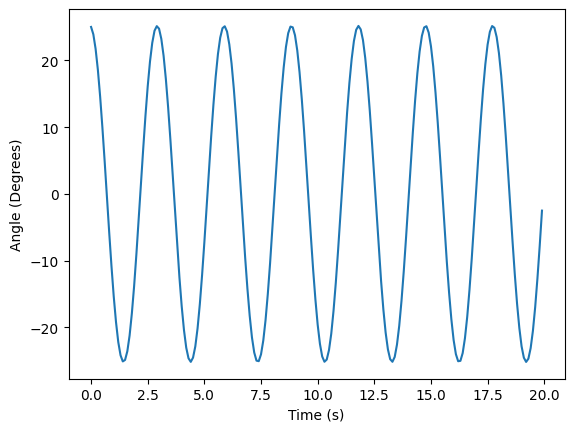

In [15]:
plt.plot(t,Θ_t)
plt.xlabel("Time (s)")
plt.ylabel("Angle (Degrees)")

###   <font color='Red'> Determine-and-Print the Period & the frequency of the plot above, using only the graph (and data above): </font>

In [27]:
period= 2.6 ## s
frequency = 1/period ## hz

print(period)
print(frequency)

2.6
0.3846153846153846


###   <font color='Red'> Next lets determine the frequency-profile of this simulation: </font>

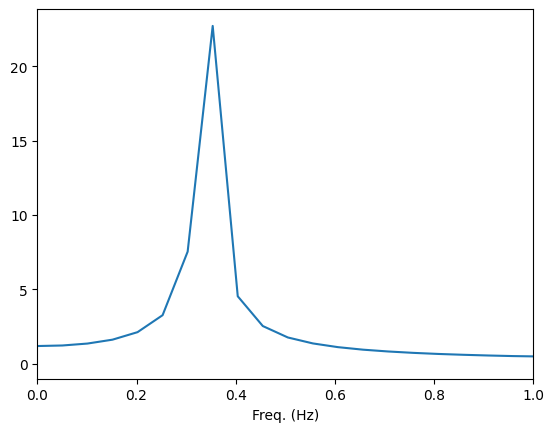

In [32]:
f, s = Experiment.frequency()

plt.plot(f,s)
plt.xlim([0,1])
plt.xlabel("Freq. (Hz)")
plt.show()

###   <font color='Red'> Next lets determine the frequency-profile of this simulation: </font>

In [36]:
S_peak = np.argmax(s)
print(S_peak)

7


#   <font color='Red'> **Mass Experiment** </font>

### <font color='Green'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [37]:
Masses = np.arange(0.1, 10, 0.1)
freqs  = np.empty(len(Masses))

for i in range(len(Masses)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = 1 ## m
    MassExperiment.mass = Masses[i] ## kg
    MassExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = MassExperiment.dynamics(5, error=0.0, dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Next let's plot our results: </font>

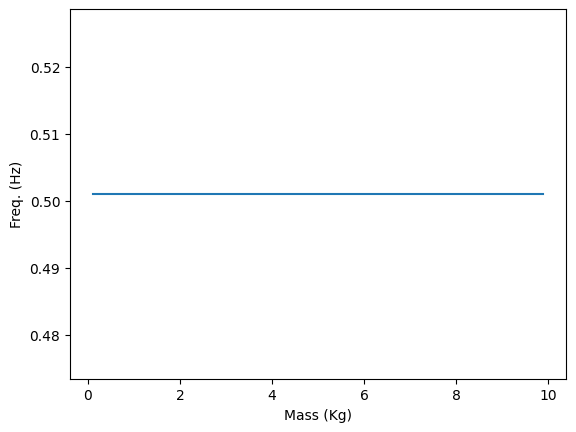

In [41]:
plt.plot(Masses, freqs)
plt.xlabel("Mass (Kg)")
plt.ylabel("Freq. (Hz)")
plt.show()

#   <font color='Red'> **Length Experiment** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [42]:
Length = np.arange(0.1, 10, 0.1)
freqs  = np.empty(len(Length))

for i in range(len(Length)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = Length[i] ## m
    MassExperiment.mass = 1 ## kg
    MassExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = MassExperiment.dynamics(5, dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

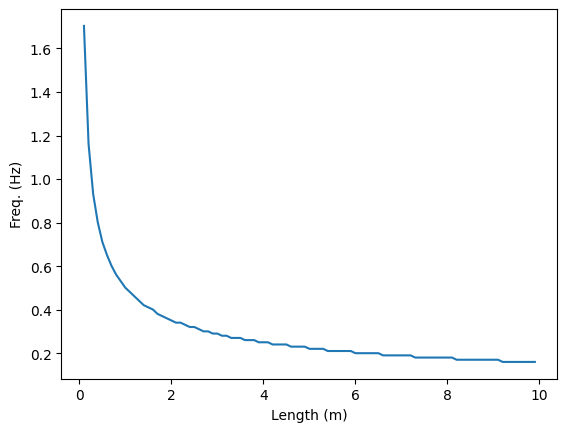

In [43]:
plt.plot(Length, freqs)
plt.xlabel("Length (m)")
plt.ylabel("Freq. (Hz)")
plt.show()

###   <font color='Red'> Let's plot our results in a linearized form: </font>

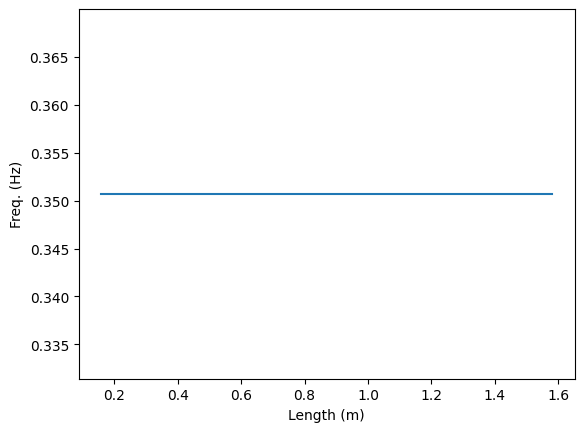

In [61]:
Linear_length= (1/np.sqrt(Length)) * MassExperiment.mass**-1/2

plt.plot(Linear_length, freqs)
plt.xlabel("Length (m)")
plt.ylabel("Freq. (Hz)")
plt.show()

#   <font color='Red'> **Gravitational Acceleration** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [55]:
Grav = np.arange(0.1, 10, 0.1) ## m/s/s
freqs  = np.empty(len(Grav))

for i in range(len(Length)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = 2.0 ## m
    MassExperiment.mass = 1 ## kg
    MassExperiment.g    = Grav[i] ## m/s/s

    t, Θ_t = MassExperiment.dynamics(5, dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

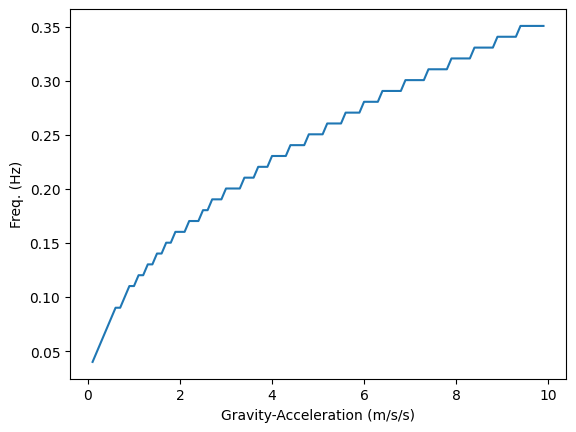

In [56]:
plt.plot(Grav, freqs)
plt.xlabel("Gravity-Acceleration (m/s/s)")
plt.ylabel("Freq. (Hz)")
plt.show()

###   <font color='Red'> Let's plot our results in linearized form: </font>

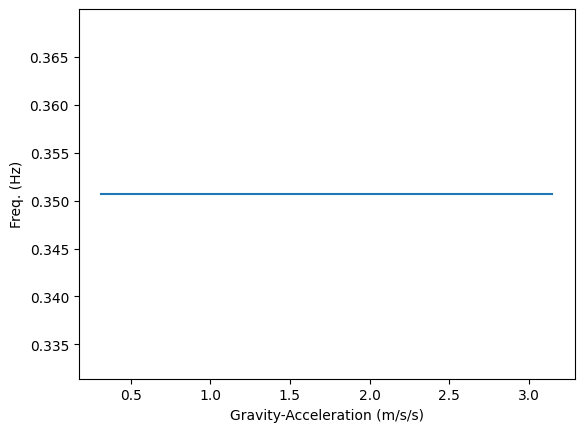

In [62]:
Lin_grav= np.sqrt(Grav)

plt.plot(Lin_grav, )
plt.xlabel("Gravity-Acceleration (m/s/s)")
plt.ylabel("Freq. (Hz)")
plt.show()

#   <font color='Red'> **Release Angle (small)** </font>

### <font color='Red'> Implement the *for-loop-over-object* stragey to scan over object parameters.</font>

In [57]:
Angle = np.arange(0.1, 10, 0.1) ## degrees
freqs  = np.empty(len(Angle))

for i in range(len(Angle)):

    MassExperiment = PhysicalPendulum()
    MassExperiment.L    = 2.0 ## m
    MassExperiment.mass = 1 ## kg
    MassExperiment.g    = 9.81 ## m/s/s

    t, Θ_t = MassExperiment.dynamics(Angle[i], dt=0.1, T = 100)
    f, S   = MassExperiment.frequency()

    freqs[i] = f[np.argmax(S)]

###   <font color='Red'> Let's plot our results as-is: </font>

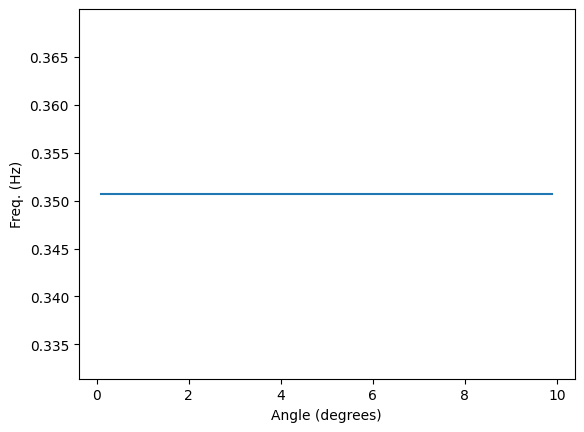

In [58]:
plt.plot(Angle, freqs)
plt.xlabel("Angle (degrees)")
plt.ylabel("Freq. (Hz)")
plt.show()

#   <font color='Red'> **Conclusion** </font>